In [28]:
%matplotlib inline
from matplotlib import pylab as plt

# A Comprehensive Analysis of Peridynamics

Alejandro Francisco Queiruga

**TL;DR:** I advise against the use of Peridynamics.

## Introduction

This notebook replicates some of the results of 

> Queiruga, A. F. and G. J. Moridis, "Numerical experiments on 
>  the convergence properties of state-based peridynamic laws and 
>  influence functions in two-dimensional problems." Computer 
>  Methods in Applied Mechanics and Engineering 322 (2017): 
>  97-122.

PeriFlakes, of which is this notebook is a part, is an open source implementation of Peridynamics that can quickly generate and analyze state-based schemes. The database in this repository contains the solutions of a huge set of runs with many permutations on the theory on constant-strain problems and the thin crack problem. 

I like to use my [SimDataDB](https://github.com/afqueiruga/SimDataDB) wrapper for cursor and entry-adding management, but the database is just a regular `sqlite3` table. There are four tables, each with with the same five columns:

In [27]:
from SimDataDB import *
sdb = SimDataDB('PeriFlakes/results.db')
print sdb.Query("SELECT name FROM sqlite_master WHERE type='table';")
print [ (_[1],_[2]) for _ in sdb.Query("PRAGMA table_info(uniaxial)")]

[[u'uniaxial']]
[(u'method', u'TEXT'), (u'weight', u'TEXT'), (u'RF', u'FLOAT'), (u'N', u'INT'), (u'u', u'array')]


The first two columns label the scheme by constitutive law and weight (influence) function $w$, $RF$ is the support radius (which is also an artificial hyperparameter!), $N$ is the number of nodes along one side of the $(-1,1)\times(-1,1)$ domain, and $u$ is a binary blob of the entire numpy array storing the solution.

# Constant Strain Problems

This is a diagram of the three main modes of constant strain:

![three modes](images/blocks.png)

(The bottom of the uniaxial and shear domains are also rollers.)

Let's access one of these solutions. The solutions are stored as flattened out arrays, so we do a reshape. Let us access one method that does not look too bad, Silling's dilation based model using a cubic influence function.

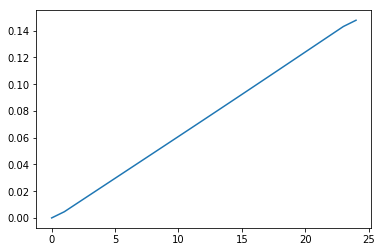

In [44]:
N,u = sdb.Query("SELECT N,u FROM uniaxial WHERE method='silling' and weight='cubic'")[0]
u = u.reshape(N,N,2)
plt.plot(u[:,N/2,1])

## Thin Crack

Those above problems 

![cracks](images/crack_diagram.png)